In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
ATLAS = "AAL+CSF"
workdir = "../braintypicality/workdir/cuda_opt/learnable"
#region_scores_raw = pd.read_csv(f"{workdir}/eval/heatmaps_v2/roi/{ATLAS}_roi_likelihoods_abcd_ibis_conte.csv")
region_scores_raw = pd.read_csv(f"{workdir}/eval/heatmaps_v2/roi/{ATLAS}_roi_harmonized_likelihoods_abcd_ibis_conte.csv")

In [3]:
cohort_means = region_scores_raw.pivot(columns='Cohort').mean(numeric_only=True)
diff = cohort_means.loc[:,'IBIS-DS']-cohort_means.loc[:,'IBIS-LR-Typical']
diff

background        0.200611
CSF               3.764922
Precentral_L      2.067770
Precentral_R      5.045920
Frontal_Sup_L     4.974999
                   ...    
Vermis_6          7.304988
Vermis_7          2.830064
Vermis_8          6.421382
Vermis_9         10.274727
Vermis_10         5.550583
Length: 118, dtype: float64

In [4]:
sorted_regions = list(diff.sort_values(ascending=False).index)
inner_scores = region_scores_raw[sorted_regions+["Cohort"]]
data = inner_scores.melt(id_vars="Cohort", var_name="Region", value_name="Anomaly Score")
data.head()

,Cohort,Region,Anomaly Score
0,ABCD-Val-Test,Vermis_9,-27.013868
1,ABCD-Val-Test,Vermis_9,-23.677731
2,ABCD-Val-Test,Vermis_9,-18.202498
3,ABCD-Val-Test,Vermis_9,-28.311645
4,ABCD-Val-Test,Vermis_9,-22.746688


[Text(0, 0, 'Cerebelum_9_L'),
 Text(1, 0, 'Frontal_Sup_Orb_R'),
 Text(2, 0, 'Temporal_Inf_R'),
 Text(3, 0, 'Cerebelum_6_L'),
 Text(4, 0, 'Frontal_Sup_R'),
 Text(5, 0, 'Angular_R'),
 Text(6, 0, 'Vermis_8'),
 Text(7, 0, 'Rectus_L'),
 Text(8, 0, 'Putamen_R'),
 Text(9, 0, 'Frontal_Mid_Orb_L')]

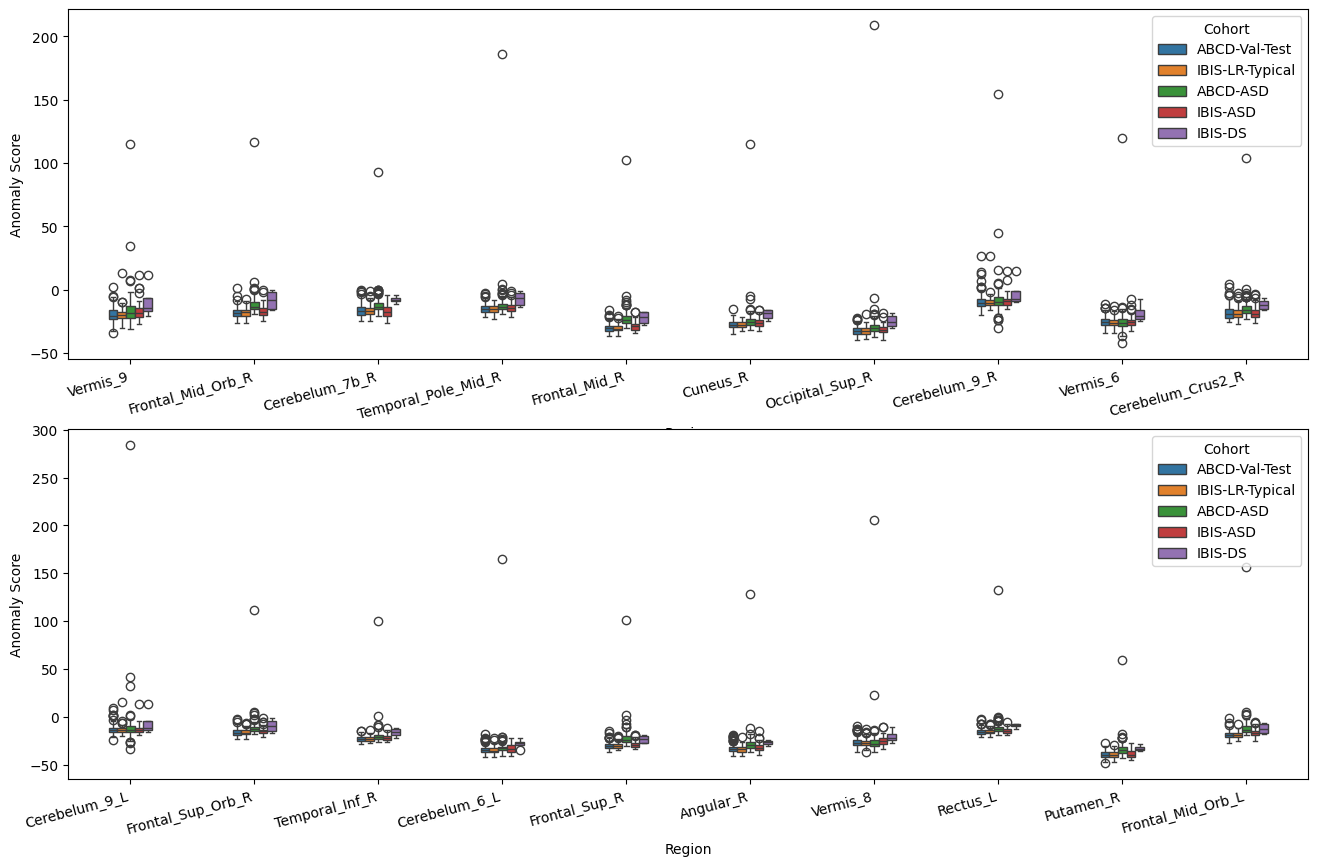

In [5]:
import warnings
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(2,1, figsize=(16,10))
ax = sns.boxplot(data=data[data.Region.isin(sorted_regions[:10])], x="Region", y="Anomaly Score", hue="Cohort", hue_order=["ABCD-Val-Test","IBIS-LR-Typical","ABCD-ASD","IBIS-ASD","IBIS-DS"], ax=axs[0],  width=0.35)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')
#ax.set_ylim(-50,50)

ax = sns.boxplot(data=data[data.Region.isin(sorted_regions[10:20])], x="Region", y="Anomaly Score", hue="Cohort", hue_order=["ABCD-Val-Test","IBIS-LR-Typical","ABCD-ASD","IBIS-ASD","IBIS-DS"], ax=axs[1],  width=0.35)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')
#ax.set_ylim(-50,20)


(-45.0, 15.0)

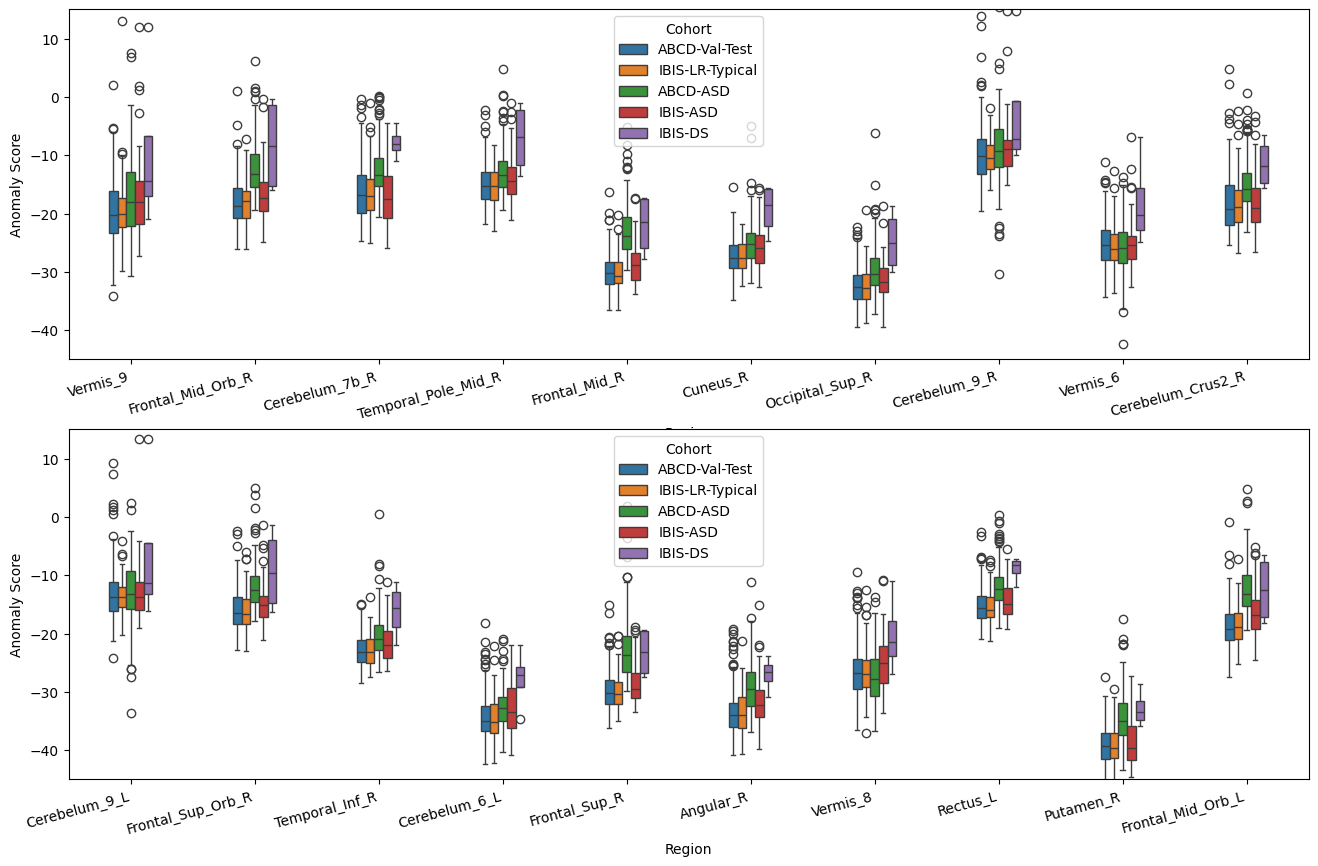

In [6]:
import warnings
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(2,1, figsize=(16,10))
ax = sns.boxplot(data=data[data.Region.isin(sorted_regions[:10])], x="Region", y="Anomaly Score", hue="Cohort", hue_order=["ABCD-Val-Test","IBIS-LR-Typical","ABCD-ASD","IBIS-ASD","IBIS-DS"], ax=axs[0],  width=0.35)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')
ax.set_ylim(-45,15)

ax = sns.boxplot(data=data[data.Region.isin(sorted_regions[10:20])], x="Region", y="Anomaly Score", hue="Cohort", hue_order=["ABCD-Val-Test","IBIS-LR-Typical","ABCD-ASD","IBIS-ASD","IBIS-DS"], ax=axs[1],  width=0.35)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')
ax.set_ylim(-45,15)

In [7]:
region_scores_raw["Cohort"].unique()

array(['ABCD-Val-Test', 'ABCD-ASD', 'IBIS-LR-Typical', 'IBIS-ASD',
       'IBIS-DS'], dtype=object)

## Classify the regional likelihoods (ABCD Inlier vs ASD)

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline

# 1) Keep only the two cohorts we care about
keep = ['IBIS-LR-Typical',  'IBIS-ASD']
df = region_scores_raw[region_scores_raw['Cohort'].isin(keep)].copy()

# 2) Drop ID, split features & labels
df = df.drop(columns=['ID'])
X = df.drop(columns=['Cohort']).values.astype(np.float32)   # shape (n_samples, 118)
y = df['Cohort'].values

# 3) Encode labels 0/1
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Classes:", le.classes_)        # ['ABCD-ASD' 'ABCD-Val-Test']
print("Label counts:", np.bincount(y_enc))

# 4) Prepare cross-validator and storage
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s = [], [], [], []

# 5) Loop folds
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_enc), 1):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y_enc[train_idx], y_enc[test_idx]

    # pipeline = scaler → MLP
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(
            hidden_layer_sizes=(128, 64),
            activation='relu',
            solver='adam',
            alpha=1e-4,
            batch_size=32,
            max_iter=200,
            random_state=42
        ))
    ])

    # train & predict
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)

    # metrics
    acc = accuracy_score(y_te, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_te, y_pred,
        average='macro',  # macro averages both classes equally
        zero_division=0
    )

    # print(f"\n--- Fold {fold} ---")
    # print(f" Accuracy:  {acc:.4f}")
    # print(f" Precision: {prec:.4f}")
    # print(f" Recall:    {rec:.4f}")
    # print(f" F1-score:  {f1:.4f}")
    # print("\n" + classification_report(
    #     y_te, y_pred,
    #     target_names=le.classes_,
    #     digits=4
    # ))

    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)

# 6) Aggregate
print("\n=== CV Summary ===")
print(f"Mean Accuracy : {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Mean Precision: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Mean Recall   : {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"Mean F1-score : {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")

accs1 = accs
precs1 = precs
recs1 = recs
f1s1 = f1s


Classes: ['IBIS-ASD' 'IBIS-LR-Typical']
Label counts: [61 82]

=== CV Summary ===
Mean Accuracy : 0.6084 ± 0.0594
Mean Precision: 0.5962 ± 0.0668
Mean Recall   : 0.5952 ± 0.0705
Mean F1-score : 0.5868 ± 0.0762


In [ ]:
# Load the CSV file back into a DataFrame. mri_info_manufacturersmn
merged_abcd_inlier = pd.read_csv("batches/batches_abcd_inlier_cols_scanner_model_sex.csv")

# new column by concatenating the two existing columns 
merged_abcd_inlier['mri_info_manufacturer_model'] = (
    merged_abcd_inlier['mri_info_manufacturer'].astype(str) +
    " | " +
    merged_abcd_inlier['mri_info_manufacturersmn'].astype(str)
)

# Create a dictionary mapping "src_subject_id" to "mri_info_manufacturer".
abcd_inlier_scanner_dict = merged_abcd_inlier.set_index("src_subject_id")["mri_info_manufacturer_model"].to_dict()

# Create a dictionary mapping "src_subject_id" to "demo_sex_v2".
abcd_inlier_sex_dict = merged_abcd_inlier.set_index("src_subject_id")["demo_sex_v2"].to_dict()

In [ ]:
# Load the CSV file back into a DataFrame. mri_info_manufacturersmn
merged_abcd_asd = pd.read_csv("batches/batches_abcd_asd_cols_scanner_model_sex.csv")

# new column by concatenating the two existing columns 
merged_abcd_asd['mri_info_manufacturer_model'] = (
    merged_abcd_asd['mri_info_manufacturer'].astype(str) +
    " | " +
    merged_abcd_asd['mri_info_manufacturersmn'].astype(str)
)

# Create a dictionary mapping "src_subject_id" to "mri_info_manufacturer".
abcd_asd_scanner_dict = merged_abcd_asd.set_index("src_subject_id")["mri_info_manufacturer_model"].to_dict()

# Create a dictionary mapping "src_subject_id" to "demo_sex_v2".
abcd_asd_sex_dict = merged_abcd_asd.set_index("src_subject_id")["demo_sex_v2"].to_dict()

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline

# --- your two scanner dicts ---
# abcd_inlier_scanner_dict : dict mapping ABCD-Val-Test IDs → scanner strings
# abcd_asd_scanner_dict    : dict mapping ABCD-ASD IDs      → scanner strings

# 1) Start from your raw DataFrame
df = region_scores_raw.copy()  # columns: 118 regions + Cohort + ID

# 2) Map each ID → scanner name (depending on Cohort)
def lookup_scanner(row):
    if row['Cohort'] == 'ABCD-Val-Test':
        return abcd_inlier_scanner_dict.get(row['ID'], None)
    elif row['Cohort'] == 'ABCD-ASD':
        return abcd_asd_scanner_dict.get(row['ID'], None)
    else:
        return None

df['Scanner'] = df.apply(lookup_scanner, axis=1)

# 3) Keep only the two Prisma variants
keep_scanners = ['SIEMENS | Prisma', 'SIEMENS | Prisma_fit']
df = df[df['Scanner'].isin(keep_scanners)].reset_index(drop=True)

# Optional: report how many samples remain per cohort
print(df['Cohort'].value_counts())

# 4) Drop unneeded columns & prepare X,y
df = df.drop(columns=['ID'])  # we don’t train on ID
X = df.drop(columns=['Cohort','Scanner']).values.astype(np.float32)
y = df['Cohort'].values

# 5) Encode the two cohorts into 0/1
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Classes:", le.classes_)
print("Counts:", np.bincount(y_enc))

# 6) Set up 5-fold CV & storage
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s = [], [], [], []

# 7) Loop through CV folds
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_enc), start=1):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y_enc[train_idx], y_enc[test_idx]

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(
            hidden_layer_sizes=(128, 64),
            activation='relu',
            solver='adam',
            alpha=1e-4,
            batch_size=32,
            max_iter=200,
            random_state=42
        ))
    ])

    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_te, y_pred, average='macro', zero_division=0
    )

    # print(f"\n--- Fold {fold} ---")
    # print(f" Accuracy:  {acc:.4f}")
    # print(f" Precision: {prec:.4f}")
    # print(f" Recall:    {rec:.4f}")
    # print(f" F1-score:  {f1:.4f}")
    # print(classification_report(y_te, y_pred, target_names=le.classes_, digits=4))

    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)

# 8) Summarize across folds
print("\n=== CV Summary ===")
print(f"Mean Accuracy : {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Mean Precision: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Mean Recall   : {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"Mean F1-score : {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")

Cohort
ABCD-Val-Test    198
ABCD-ASD         102
Name: count, dtype: int64
Classes: ['ABCD-ASD' 'ABCD-Val-Test']
Counts: [102 198]

=== CV Summary ===
Mean Accuracy : 0.9433 ± 0.0374
Mean Precision: 0.9329 ± 0.0417
Mean Recall   : 0.9426 ± 0.0423
Mean F1-score : 0.9373 ± 0.0418


In [12]:
print("\n=== CV Summary === All Scanners ===")
print(f"Mean Accuracy : {np.mean(accs1):.4f} ± {np.std(accs1):.4f}")
print(f"Mean Precision: {np.mean(precs1):.4f} ± {np.std(precs1):.4f}")
print(f"Mean Recall   : {np.mean(recs1):.4f} ± {np.std(recs1):.4f}")
print(f"Mean F1-score : {np.mean(f1s1):.4f} ± {np.std(f1s1):.4f}")

print("\n=== CV Summary === Siemens ===")
print(f"Mean Accuracy : {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Mean Precision: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Mean Recall   : {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"Mean F1-score : {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")



=== CV Summary === All Scanners ===
Mean Accuracy : 0.6084 ± 0.0594
Mean Precision: 0.5962 ± 0.0668
Mean Recall   : 0.5952 ± 0.0705
Mean F1-score : 0.5868 ± 0.0762

=== CV Summary === Siemens ===
Mean Accuracy : 0.9433 ± 0.0374
Mean Precision: 0.9329 ± 0.0417
Mean Recall   : 0.9426 ± 0.0423
Mean F1-score : 0.9373 ± 0.0418


In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.utils import resample

# 1) Define cohorts
train_cohorts = ['ABCD-Val-Test', 'ABCD-ASD']
test_cohorts  = ['IBIS-LR-Typical', 'IBIS-ASD']

# 2) Filter DataFrame
df_train = region_scores_raw[region_scores_raw['Cohort'].isin(train_cohorts)].copy()
df_test  = region_scores_raw[region_scores_raw['Cohort'].isin(test_cohorts)].copy()

# 3) Split features/labels
def split_xy(df):
    X = df.drop(columns=['ID', 'Cohort']).values.astype(np.float32)
    y = df['Cohort'].values
    return X, y
X_train_raw, y_train = split_xy(df_train)
X_test_raw,  y_test  = split_xy(df_test)

# 4) Encode labels consistently
label_map = {
    'ABCD-Val-Test':   0,
    'IBIS-LR-Typical': 0,
    'ABCD-ASD':        1,
    'IBIS-ASD':        1
}
y_train_enc = np.array([label_map[c] for c in y_train])
y_test_enc  = np.array([label_map[c] for c in y_test])
print("Original training class counts:", np.bincount(y_train_enc))

# 5) Standard normalization: fit on raw training, apply to both train & test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

# 6) Balance training data by oversampling minority class
classes, counts = np.unique(y_train_enc, return_counts=True)
max_count = counts.max()
X_resampled, y_resampled = [], []
for cls in classes:
    X_cls = X_train[y_train_enc == cls]
    y_cls = y_train_enc[y_train_enc == cls]
    X_up, y_up = resample(X_cls, y_cls, replace=True, n_samples=max_count, random_state=42)
    X_resampled.append(X_up)
    y_resampled.append(y_up)
X_train_bal = np.vstack(X_resampled)
y_train_bal = np.hstack(y_resampled)
# Shuffle balanced set
perm = np.random.RandomState(42).permutation(len(y_train_bal))
X_train_bal, y_train_bal = X_train_bal[perm], y_train_bal[perm]
print("Balanced training class counts:", np.bincount(y_train_bal))

# 7) Define base estimator (MLP)
base_estimator = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu', solver='adam', alpha=1e-4,
    batch_size=32, max_iter=200, random_state=42
)

# 8) Bagging ensemble for majority vote
clf = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=5,
    oob_score=True,
    random_state=42
)
clf.fit(X_train_bal, y_train_bal)

# 9) OOB validation
oob_preds = np.argmax(clf.oob_decision_function_, axis=1)
acc_val = accuracy_score(y_train_bal, oob_preds)
prec_val, rec_val, f1_val, _ = precision_recall_fscore_support(
    y_train_bal, oob_preds, average='macro', zero_division=0
)
print("=== Validation (OOB) Metrics ===")
print(f"Accuracy : {acc_val:.4f}")
print(f"Precision: {prec_val:.4f} | Recall: {rec_val:.4f} | F1-score: {f1_val:.4f}")
print(classification_report(y_train_bal, oob_preds, target_names=['Inlier','ASD'], digits=4))

# 10) Test on IBIS cohorts
y_test_pred = clf.predict(X_test)
acc_test = accuracy_score(y_test_enc, y_test_pred)
prec_test, rec_test, f1_test, _ = precision_recall_fscore_support(
    y_test_enc, y_test_pred, average='macro', zero_division=0
)
print("=== Test Metrics ===")
print(f"Accuracy : {acc_test:.4f}")
print(f"Precision: {prec_test:.4f} | Recall: {rec_test:.4f} | F1-score: {f1_test:.4f}")
print(classification_report(y_test_enc, y_test_pred, target_names=['Inlier','ASD'], digits=4))


Original training class counts: [328 163]
Balanced training class counts: [328 328]
=== Validation (OOB) Metrics ===
Accuracy : 0.9253
Precision: 0.9308 | Recall: 0.9253 | F1-score: 0.9251
              precision    recall  f1-score   support

      Inlier     0.8822    0.9817    0.9293       328
         ASD     0.9794    0.8689    0.9208       328

    accuracy                         0.9253       656
   macro avg     0.9308    0.9253    0.9251       656
weighted avg     0.9308    0.9253    0.9251       656

=== Test Metrics ===
Accuracy : 0.5734
Precision: 0.5389 | Recall: 0.5084 | F1-score: 0.4174
              precision    recall  f1-score   support

      Inlier     0.5778    0.9512    0.7189        82
         ASD     0.5000    0.0656    0.1159        61

    accuracy                         0.5734       143
   macro avg     0.5389    0.5084    0.4174       143
weighted avg     0.5446    0.5734    0.4617       143



In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.utils import resample

# 1) Define cohorts
train_cohorts = ['IBIS-LR-Typical', 'IBIS-ASD']
test_cohorts  = ['ABCD-Val-Test', 'ABCD-ASD']

# 2) Filter DataFrame
df_train = region_scores_raw[region_scores_raw['Cohort'].isin(train_cohorts)].copy()
df_test  = region_scores_raw[region_scores_raw['Cohort'].isin(test_cohorts)].copy()

# 3) Split features/labels
def split_xy(df):
    X = df.drop(columns=['ID', 'Cohort']).values.astype(np.float32)
    y = df['Cohort'].values
    return X, y
X_train_raw, y_train = split_xy(df_train)
X_test_raw,  y_test  = split_xy(df_test)

# 4) Encode labels consistently
label_map = {
    'ABCD-Val-Test':   0,
    'IBIS-LR-Typical': 0,
    'ABCD-ASD':        1,
    'IBIS-ASD':        1
}
y_train_enc = np.array([label_map[c] for c in y_train])
y_test_enc  = np.array([label_map[c] for c in y_test])
print("Original training class counts:", np.bincount(y_train_enc))

# 5) Standard normalization: fit on raw training, apply to both train & test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

# 6) Balance training data by oversampling minority class
classes, counts = np.unique(y_train_enc, return_counts=True)
max_count = counts.max()
X_resampled, y_resampled = [], []
for cls in classes:
    X_cls = X_train[y_train_enc == cls]
    y_cls = y_train_enc[y_train_enc == cls]
    X_up, y_up = resample(X_cls, y_cls, replace=True, n_samples=max_count, random_state=42)
    X_resampled.append(X_up)
    y_resampled.append(y_up)
X_train_bal = np.vstack(X_resampled)
y_train_bal = np.hstack(y_resampled)
# Shuffle balanced set
perm = np.random.RandomState(42).permutation(len(y_train_bal))
X_train_bal, y_train_bal = X_train_bal[perm], y_train_bal[perm]
print("Balanced training class counts:", np.bincount(y_train_bal))

# 7) Define base estimator (MLP)
base_estimator = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu', solver='adam', alpha=1e-4,
    batch_size=32, max_iter=200, random_state=42
)

# 8) Bagging ensemble for majority vote
clf = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=5,
    oob_score=True,
    random_state=42
)
clf.fit(X_train_bal, y_train_bal)

# 9) OOB validation
oob_preds = np.argmax(clf.oob_decision_function_, axis=1)
acc_val = accuracy_score(y_train_bal, oob_preds)
prec_val, rec_val, f1_val, _ = precision_recall_fscore_support(
    y_train_bal, oob_preds, average='macro', zero_division=0
)
print("=== Validation (OOB) Metrics ===")
print(f"Accuracy : {acc_val:.4f}")
print(f"Precision: {prec_val:.4f} | Recall: {rec_val:.4f} | F1-score: {f1_val:.4f}")
print(classification_report(y_train_bal, oob_preds, target_names=['Inlier','ASD'], digits=4))

# 10) Test on IBIS cohorts
y_test_pred = clf.predict(X_test)
acc_test = accuracy_score(y_test_enc, y_test_pred)
prec_test, rec_test, f1_test, _ = precision_recall_fscore_support(
    y_test_enc, y_test_pred, average='macro', zero_division=0
)
print("=== Test Metrics ===")
print(f"Accuracy : {acc_test:.4f}")
print(f"Precision: {prec_test:.4f} | Recall: {rec_test:.4f} | F1-score: {f1_test:.4f}")
print(classification_report(y_test_enc, y_test_pred, target_names=['Inlier','ASD'], digits=4))


Original training class counts: [82 61]
Balanced training class counts: [82 82]


=== Validation (OOB) Metrics ===
Accuracy : 0.7866
Precision: 0.7940 | Recall: 0.7866 | F1-score: 0.7852
              precision    recall  f1-score   support

      Inlier     0.7474    0.8659    0.8023        82
         ASD     0.8406    0.7073    0.7682        82

    accuracy                         0.7866       164
   macro avg     0.7940    0.7866    0.7852       164
weighted avg     0.7940    0.7866    0.7852       164

=== Test Metrics ===
Accuracy : 0.7026
Precision: 0.6717 | Recall: 0.6818 | F1-score: 0.6751
              precision    recall  f1-score   support

      Inlier     0.7974    0.7439    0.7697       328
         ASD     0.5459    0.6196    0.5805       163

    accuracy                         0.7026       491
   macro avg     0.6717    0.6818    0.6751       491
weighted avg     0.7139    0.7026    0.7069       491

